In [155]:
from sklearn.model_selection import train_test_split
from apscheduler.schedulers.background import BackgroundScheduler
from apscheduler.schedulers.blocking import BlockingScheduler
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client import InfluxDBClient
from dotenv import load_dotenv
import pandas as pd
import datetime
import requests
import joblib
import os

### 데이터 수집

In [156]:
# InfluxDB 접속 정보 불러오기
load_dotenv('secret.env')

DB_URL=os.getenv('DB_URL')
DB_TOKEN=os.getenv('DB_TOKEN')
DB_ORG=os.getenv('DB_ORG')
DB_BUCKET=os.getenv('DB_BUCKET')

In [157]:
# InfluxDB에서 주어진 측정치에 대한 데이터를 조회하여 DataFrame으로 반환.
def query_influx(measurement, place):
    client = InfluxDBClient(url=DB_URL, token=DB_TOKEN, org=DB_ORG, timeout=30_000)
    query_api = client.query_api()
    
    query = f'''
    import "date"
    import "experimental/query"
    from(bucket: "{DB_BUCKET}")
    |> range(start: date.sub(d: 2d, from: date.truncate(t: now(), unit: 1d)), stop: now())
    |> filter(fn: (r) => r["_measurement"] == "{measurement}")
    |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
    |> filter(fn: (r) => r.place == "{place}")
    '''
    
    result_df = query_api.query_data_frame(org=DB_ORG, query=query)
    print(f"{place} {measurement} shape: ", result_df.shape)
    
    client.close()
    return result_df

outdoor_temperature_df = query_influx("temperature", "outdoor")
outdoor_humidity_df = query_influx("humidity", "outdoor")
temperature_df = query_influx("temperature", "class_a")
humidity_df = query_influx("humidity", "class_a")
people_count_df = query_influx("total_people_count", "class_a")
magnet_status_df = query_influx("magnet_status", "class_a")


outdoor temperature shape:  (263, 10)
outdoor humidity shape:  (263, 10)
class_a temperature shape:  (9149, 10)
class_a humidity shape:  (9149, 10)
class_a total_people_count shape:  (7808, 10)
class_a magnet_status shape:  (351, 10)


### 데이터 전처리

In [158]:
# 필요없는 컬럼 삭제 및 한국시간으로 시간대 변환
def clean_and_convert_time(df):
    df = df.drop(columns=['_start', '_stop', 'result', 'table', 'topic', 'device'])
    df['_time'] = pd.to_datetime(df['_time']).dt.tz_convert('Asia/Seoul').dt.tz_localize(None)
    
    return df


temperature_outdoor_df = clean_and_convert_time(outdoor_temperature_df)
humidity_outdoor_df = clean_and_convert_time(outdoor_humidity_df)
temperature_class_a_df = clean_and_convert_time(temperature_df)
humidity_class_a_df = clean_and_convert_time(humidity_df)
people_count_df = clean_and_convert_time(people_count_df)
magnet_status_df = clean_and_convert_time(magnet_status_df)

In [159]:
print("info : ", temperature_outdoor_df.head(), '\n')
print("info : ", humidity_outdoor_df.head(), '\n')
print("info : ", temperature_class_a_df.head(), '\n')
print("info : ", humidity_class_a_df.head(), '\n')
print("info : ", people_count_df.head(), '\n')
print("info : ", magnet_status_df.head(), '\n')

info :                         _time _measurement    place  value
0 2024-04-23 17:38:10.170493  temperature  outdoor   18.6
1 2024-04-23 17:48:10.570783  temperature  outdoor   18.5
2 2024-04-23 17:58:09.953316  temperature  outdoor   18.4
3 2024-04-23 18:08:10.380200  temperature  outdoor   18.4
4 2024-04-23 18:18:10.775806  temperature  outdoor   18.4 

info :                         _time _measurement    place  value
0 2024-04-23 17:38:10.183036     humidity  outdoor   53.5
1 2024-04-23 17:48:10.583670     humidity  outdoor   54.0
2 2024-04-23 17:58:09.966480     humidity  outdoor   54.0
3 2024-04-23 18:08:10.393524     humidity  outdoor   54.5
4 2024-04-23 18:18:10.788553     humidity  outdoor   55.0 

info :                         _time _measurement    place  value
0 2024-04-23 09:00:09.410287  temperature  class_a   22.5
1 2024-04-23 09:00:27.623917  temperature  class_a   21.5
2 2024-04-23 09:00:49.373604  temperature  class_a   23.0
3 2024-04-23 09:01:09.410673  temperature  c

In [160]:
# resample로 1분단위로 데이터를 합치기 위해 Datetime을 인덱스로 지정
# value에 대해 1분 단위로 평균 or 마지막값 계산. resample을 수행한 후에는 Series 객체가 됨.
def resample_data(df, column, freq, method):
    df = df.set_index('_time')

    if method == 'mean':
        return df[column].resample(freq).mean()
    elif method == 'last':
        return df[column].resample(freq).last()

outdoor_temperature_summary_series = resample_data(temperature_outdoor_df, 'value', 'T', 'mean')
outdoor_humidity_summary_series = resample_data(humidity_outdoor_df, 'value', 'T', 'mean')
temperature_summary_series = resample_data(temperature_class_a_df, 'value', 'T', 'mean')
humidity_summary_series = resample_data(humidity_class_a_df, 'value', 'T', 'mean')
people_count_series = resample_data(people_count_df, 'value', 'T', 'last')
magnet_status_series = resample_data(magnet_status_df, 'value', 'T', 'last')

print(outdoor_temperature_summary_series.head(),'\n', outdoor_humidity_summary_series.head(),'\n', temperature_summary_series.head(),'\n', humidity_summary_series.head(),'\n', people_count_series.head(),'\n',magnet_status_series.head(),'\n')

_time
2024-04-23 17:38:00    18.6
2024-04-23 17:39:00     NaN
2024-04-23 17:40:00     NaN
2024-04-23 17:41:00     NaN
2024-04-23 17:42:00     NaN
Freq: T, Name: value, dtype: float64 
 _time
2024-04-23 17:38:00    53.5
2024-04-23 17:39:00     NaN
2024-04-23 17:40:00     NaN
2024-04-23 17:41:00     NaN
2024-04-23 17:42:00     NaN
Freq: T, Name: value, dtype: float64 
 _time
2024-04-23 09:00:00    22.333333
2024-04-23 09:01:00    22.750000
2024-04-23 09:02:00    22.333333
2024-04-23 09:03:00    22.750000
2024-04-23 09:04:00    22.333333
Freq: T, Name: value, dtype: float64 
 _time
2024-04-23 09:00:00    43.666667
2024-04-23 09:01:00    42.000000
2024-04-23 09:02:00    43.666667
2024-04-23 09:03:00    42.250000
2024-04-23 09:04:00    43.833333
Freq: T, Name: value, dtype: float64 
 _time
2024-04-23 09:00:00    5.0
2024-04-23 09:01:00    6.0
2024-04-23 09:02:00    6.0
2024-04-23 09:03:00    6.0
2024-04-23 09:04:00    8.0
Freq: T, Name: value, dtype: float64 
 _time
2024-04-23 09:08:00    o

In [161]:
data_df = pd.DataFrame({
    'outdoor_temperature': outdoor_temperature_summary_series,
    'outdoor_humidity': outdoor_humidity_summary_series,
    'temperature': temperature_summary_series,
    'humidity': humidity_summary_series,
    'people_count': people_count_series,
    'air_conditional': magnet_status_series
})

print(data_df)

                     outdoor_temperature  outdoor_humidity  temperature  \
_time                                                                     
2024-04-23 09:00:00                  NaN               NaN    22.333333   
2024-04-23 09:01:00                  NaN               NaN    22.750000   
2024-04-23 09:02:00                  NaN               NaN    22.333333   
2024-04-23 09:03:00                  NaN               NaN    22.750000   
2024-04-23 09:04:00                  NaN               NaN    22.333333   
...                                  ...               ...          ...   
2024-04-25 14:13:00                  NaN               NaN    25.500000   
2024-04-25 14:14:00                  NaN               NaN    25.500000   
2024-04-25 14:15:00                  NaN               NaN    25.066667   
2024-04-25 14:16:00                  NaN               NaN    25.450000   
2024-04-25 14:17:00                  NaN               NaN    24.850000   

                      hu

In [162]:
null_values = data_df.isnull().sum()
print('Initial null value:\n', null_values)

# 'air_conditional' 컬럼의 첫 번째 값이 결측치인 경우 'close'로 설정
if pd.isna(data_df.loc[data_df.index[0], 'air_conditional']):
    data_df.at[data_df.index[0], 'air_conditional'] = 'close'

if pd.isna(data_df.loc[data_df.index[0], 'outdoor_temperature']):
    avg_temperature = data_df['outdoor_temperature'].mean()
    data_df.at[data_df.index[0], 'outdoor_temperature'] = avg_temperature

if pd.isna(data_df.loc[data_df.index[0], 'outdoor_humidity']):
    avg_humidity = data_df['outdoor_humidity'].mean()
    data_df.at[data_df.index[0], 'outdoor_humidity'] = avg_humidity

# people_count' 컬럼에서 첫 번째 값이 결측치인 경우, 최근 유효 값으로 채우기
if pd.isna(data_df.loc[data_df.index[0], 'people_count']):
    notnull_peoplecount = data_df[data_df['people_count'].notnull()].iloc[0]['people_count']
    data_df.at[data_df.index[0], 'people_count'] = notnull_peoplecount

# 나머지 결측치 전방 채우기
data_df_filled = data_df.fillna(method='ffill', axis=0)

print('After processing null value: \n', data_df_filled.isnull().sum())

Initial null value:
 outdoor_temperature    2935
outdoor_humidity       2935
temperature               0
humidity                  0
people_count             13
air_conditional        2867
dtype: int64
After processing null value: 
 outdoor_temperature    0
outdoor_humidity       0
temperature            0
humidity               0
people_count           0
air_conditional        0
dtype: int64


In [163]:
print(data_df_filled)
print(data_df_filled.shape)

                     outdoor_temperature  outdoor_humidity  temperature  \
_time                                                                     
2024-04-23 09:00:00            17.538023         58.385932    22.333333   
2024-04-23 09:01:00            17.538023         58.385932    22.750000   
2024-04-23 09:02:00            17.538023         58.385932    22.333333   
2024-04-23 09:03:00            17.538023         58.385932    22.750000   
2024-04-23 09:04:00            17.538023         58.385932    22.333333   
...                                  ...               ...          ...   
2024-04-25 14:13:00            20.900000         45.000000    25.500000   
2024-04-25 14:14:00            20.900000         45.000000    25.500000   
2024-04-25 14:15:00            20.900000         45.000000    25.066667   
2024-04-25 14:16:00            20.900000         45.000000    25.450000   
2024-04-25 14:17:00            20.900000         45.000000    24.850000   

                      hu

In [164]:
# 날짜값 제거
data_df_filled_delete_date = data_df_filled
data_df_filled_delete_date.index = data_df_filled_delete_date.index.time
print(data_df_filled_delete_date.head())

          outdoor_temperature  outdoor_humidity  temperature   humidity  \
09:00:00            17.538023         58.385932    22.333333  43.666667   
09:01:00            17.538023         58.385932    22.750000  42.000000   
09:02:00            17.538023         58.385932    22.333333  43.666667   
09:03:00            17.538023         58.385932    22.750000  42.250000   
09:04:00            17.538023         58.385932    22.333333  43.833333   

          people_count air_conditional  
09:00:00           5.0           close  
09:01:00           6.0           close  
09:02:00           6.0           close  
09:03:00           6.0           close  
09:04:00           8.0           close  


In [165]:
# air_conditional의 값이 close면 0, open이면 1로 변경
data_df_filled_delete_date['air_conditional'] = data_df_filled_delete_date['air_conditional'].map({'close': 0, 'open': 1})

print(data_df_filled_delete_date.head())
print(data_df_filled_delete_date.info)

          outdoor_temperature  outdoor_humidity  temperature   humidity  \
09:00:00            17.538023         58.385932    22.333333  43.666667   
09:01:00            17.538023         58.385932    22.750000  42.000000   
09:02:00            17.538023         58.385932    22.333333  43.666667   
09:03:00            17.538023         58.385932    22.750000  42.250000   
09:04:00            17.538023         58.385932    22.333333  43.833333   

          people_count  air_conditional  
09:00:00           5.0                0  
09:01:00           6.0                0  
09:02:00           6.0                0  
09:03:00           6.0                0  
09:04:00           8.0                0  
<bound method DataFrame.info of           outdoor_temperature  outdoor_humidity  temperature   humidity  \
09:00:00            17.538023         58.385932    22.333333  43.666667   
09:01:00            17.538023         58.385932    22.750000  42.000000   
09:02:00            17.538023         58

In [166]:
# 상관계수 계산
correlation_matrix = data_df_filled.corr()
print(correlation_matrix)

                     outdoor_temperature  outdoor_humidity  temperature  \
outdoor_temperature             1.000000         -0.848912     0.803989   
outdoor_humidity               -0.848912          1.000000    -0.714657   
temperature                     0.803989         -0.714657     1.000000   
humidity                       -0.519634          0.804537    -0.540853   
people_count                    0.429936         -0.285980     0.393392   
air_conditional                 0.260457         -0.036994    -0.097329   

                     humidity  people_count  air_conditional  
outdoor_temperature -0.519634      0.429936         0.260457  
outdoor_humidity     0.804537     -0.285980        -0.036994  
temperature         -0.540853      0.393392        -0.097329  
humidity             1.000000      0.062359         0.303739  
people_count         0.062359      1.000000         0.422522  
air_conditional      0.303739      0.422522         1.000000  


### 데이터 시각화

/home/gahyoung/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


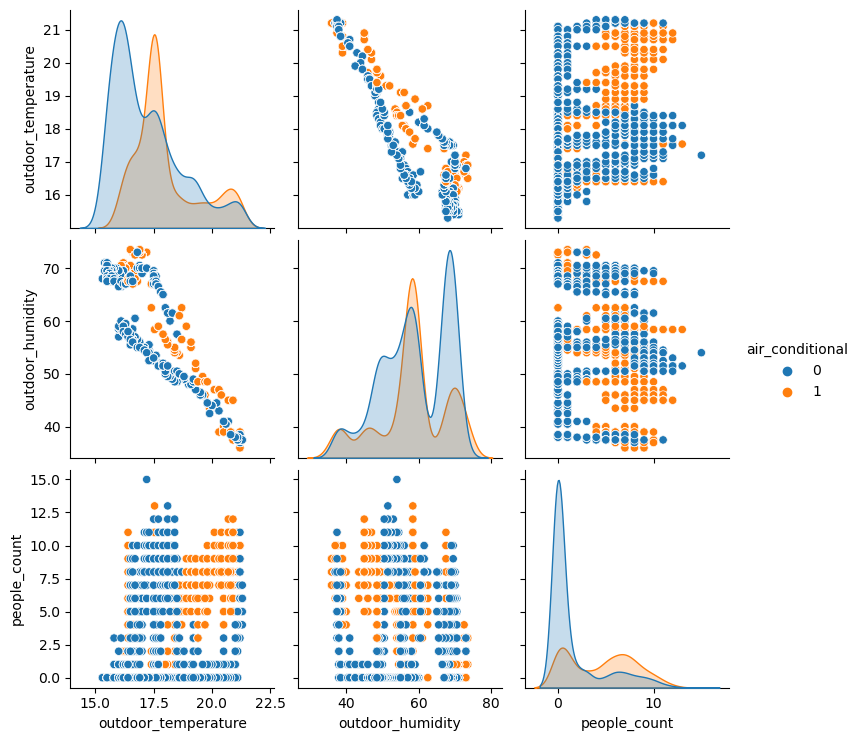

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns

# 산점도 그리기
sns.pairplot(data_df_filled_delete_date, hue='air_conditional', vars=['outdoor_temperature', 'outdoor_humidity', 'people_count'])
plt.show()

### 분석 결과
outdoor_temperature 또는 outdoor_humidity가 높을때 people_count가 높다면 에어컨을 키는 빈도가 늘어난다.

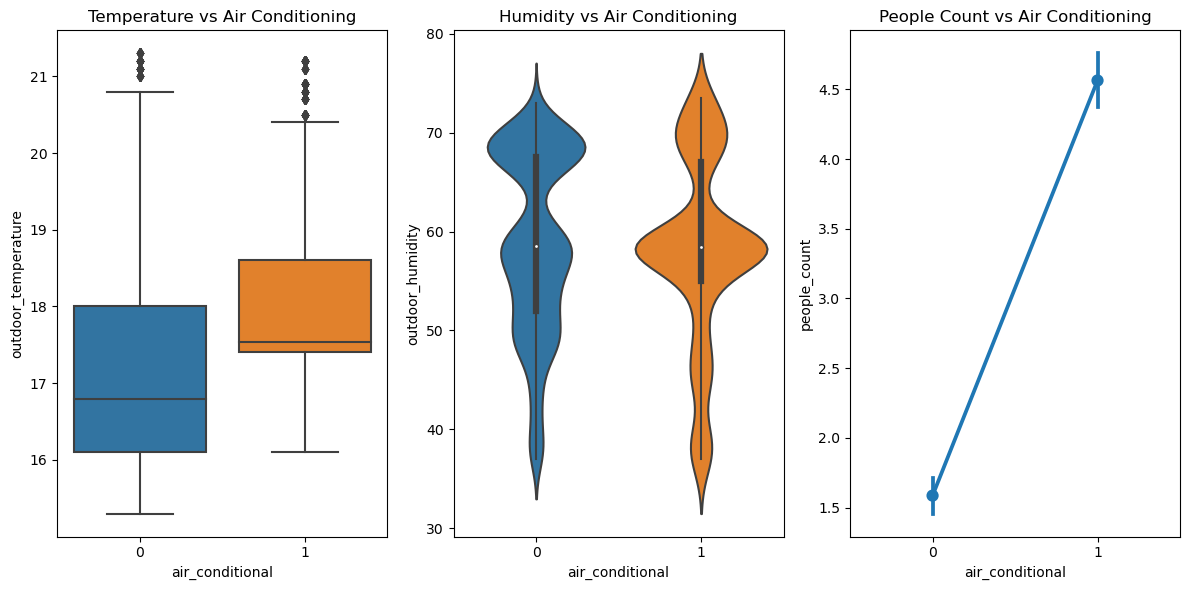

In [182]:

# 데이터 세트 설정
data = data_df_filled_delete_date  # 데이터 프레임 이름을 'data_df_filled'에서 'data'로 변경했습니다.

# 1. 온도와 에어컨의 상관관계 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.boxplot(x='air_conditional', y='outdoor_temperature', data=data)
plt.title('Temperature vs Air Conditioning')

# 2. 습도와 에어컨의 상관관계 시각화
plt.subplot(1, 3, 2)
sns.violinplot(x='air_conditional', y='outdoor_humidity', data=data)
plt.title('Humidity vs Air Conditioning')

# 3. 재실 인원과 에어컨의 상관관계 시각화
plt.subplot(1, 3, 3)
sns.pointplot(x='air_conditional', y='people_count', data=data)
plt.title('People Count vs Air Conditioning')

plt.tight_layout()
plt.show()


### 모델링
1. 데이터 분할

In [172]:
# 훈련데이터와 테스트 데이터 분리
X = data_df_filled[['temperature', 'humidity', 'people_count']]
y = data_df_filled['air_conditional']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

2. 모델 훈련 및 평가

In [173]:
# 로지스틱 회귀
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 데이터 준비: X는 온도와 습도, y는 에어컨의 ON/OFF 상태
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 생성 및 학습
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

# 모델 평가
from sklearn.metrics import accuracy_score
log_reg_predictions = log_reg_model.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)

In [174]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestClassifier

# 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 생성 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 예측 및 성능 평가
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

In [175]:
# XG 부스트
import xgboost as xgb

# 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 생성 및 학습
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgboost_model.fit(X_train, y_train)

# 예측 및 성능 평가
xgboost_predictions = xgboost_model.predict(X_test)
xgboost_accuracy = accuracy_score(y_test, xgboost_predictions)

In [176]:
print("LogisticRegression Accuracy:", log_reg_accuracy)
print("RandomForest Accuracy:", rf_accuracy)
print("XGBoost Accuracy:", xgboost_accuracy)

LogisticRegression Accuracy: 0.75625
RandomForest Accuracy: 0.953125
XGBoost Accuracy: 0.9546875


In [177]:
print(y.value_counts())

0    1950
1    1248
Name: air_conditional, dtype: int64


In [178]:
from sklearn.metrics import classification_report

print(classification_report(y_test, log_reg_predictions))
print(classification_report(y_test, rf_predictions))
print(classification_report(y_test, xgboost_predictions))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81       390
           1       0.73      0.60      0.66       250

    accuracy                           0.76       640
   macro avg       0.75      0.73      0.73       640
weighted avg       0.75      0.76      0.75       640

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       390
           1       0.94      0.94      0.94       250

    accuracy                           0.95       640
   macro avg       0.95      0.95      0.95       640
weighted avg       0.95      0.95      0.95       640

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       390
           1       0.94      0.94      0.94       250

    accuracy                           0.95       640
   macro avg       0.95      0.95      0.95       640
weighted avg       0.95      0.95      0.95       640



3. 모델 선택

In [179]:
# 모델 저장 경로와 파일 이름 설정
MODEL_NAME = 'air_conditional_ai_model.joblib'
MODEL_PATH = './' 

# 모델 저장
joblib.dump(rf_model, MODEL_PATH + MODEL_NAME)

['./air_conditional_ai_model.joblib']

### NHN Cloud Object Storage에 모델 업로드

In [180]:
class ObjectService:
    def __init__(self, storage_url, token_id):
        self.storage_url = storage_url
        self.token_id = token_id

    def _get_url(self, container, object):
        return '/'.join([self.storage_url, container, object])

    def _get_request_header(self):
        return {'X-Auth-Token': self.token_id}

    def upload(self, container, object, object_path):
        req_url = self._get_url(container, object)
        req_header = self._get_request_header()

        path = '/'.join([object_path, object])
        with open(path, 'rb') as f:
            return requests.put(req_url, headers=req_header, data=f.read())


if __name__ == '__main__':

    STORAGE_URL = os.getenv('STORAGE_URL')
    ACCESS_TOKEN_ID = os.getenv('ACCESS_TOKEN_ID')
    CONTAINER_NAME = os.getenv('CONTAINER_NAME')
    OBJECT_PATH = '.' 
    
    obj_service = ObjectService(STORAGE_URL, ACCESS_TOKEN_ID)

    obj_service.upload(CONTAINER_NAME, MODEL_NAME, OBJECT_PATH)